# 🧮 Multiple Linear Regression

- Triển khai MultipleLinearRegression với tùy chọn regularization (Ridge/Lasso/ElasticNet)
- Chuẩn hóa đặc trưng và so sánh hiệu năng
- Học đường cong hội tụ

## Mục tiêu

Trong notebook này, chúng ta sẽ:
1. Triển khai Multiple Linear Regression với nhiều đặc trưng
2. So sánh các phương pháp regularization (Ridge, Lasso, ElasticNet)
3. Tìm hiểu về chuẩn hóa đặc trưng và tác động của nó
4. Phân tích đường cong hội tụ và hiệu năng mô hình
5. Visualize kết quả và so sánh với sklearn


In [17]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Thêm đường dẫn src vào sys.path để import được các module
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))

from linear_regression import MultipleLinearRegression
from data_generator import DataGenerator
from visualization import Plotter

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🧮 Multiple Linear Regression từ đầu")
print("=" * 50)


🧮 Multiple Linear Regression từ đầu


Data shape: X=(500, 3), y=(500,)
True weights: [3.0, 2.0, -1.0]
True bias: 5.0
X range: [-9.91, 9.99]
y range: [-46.54, 61.84]


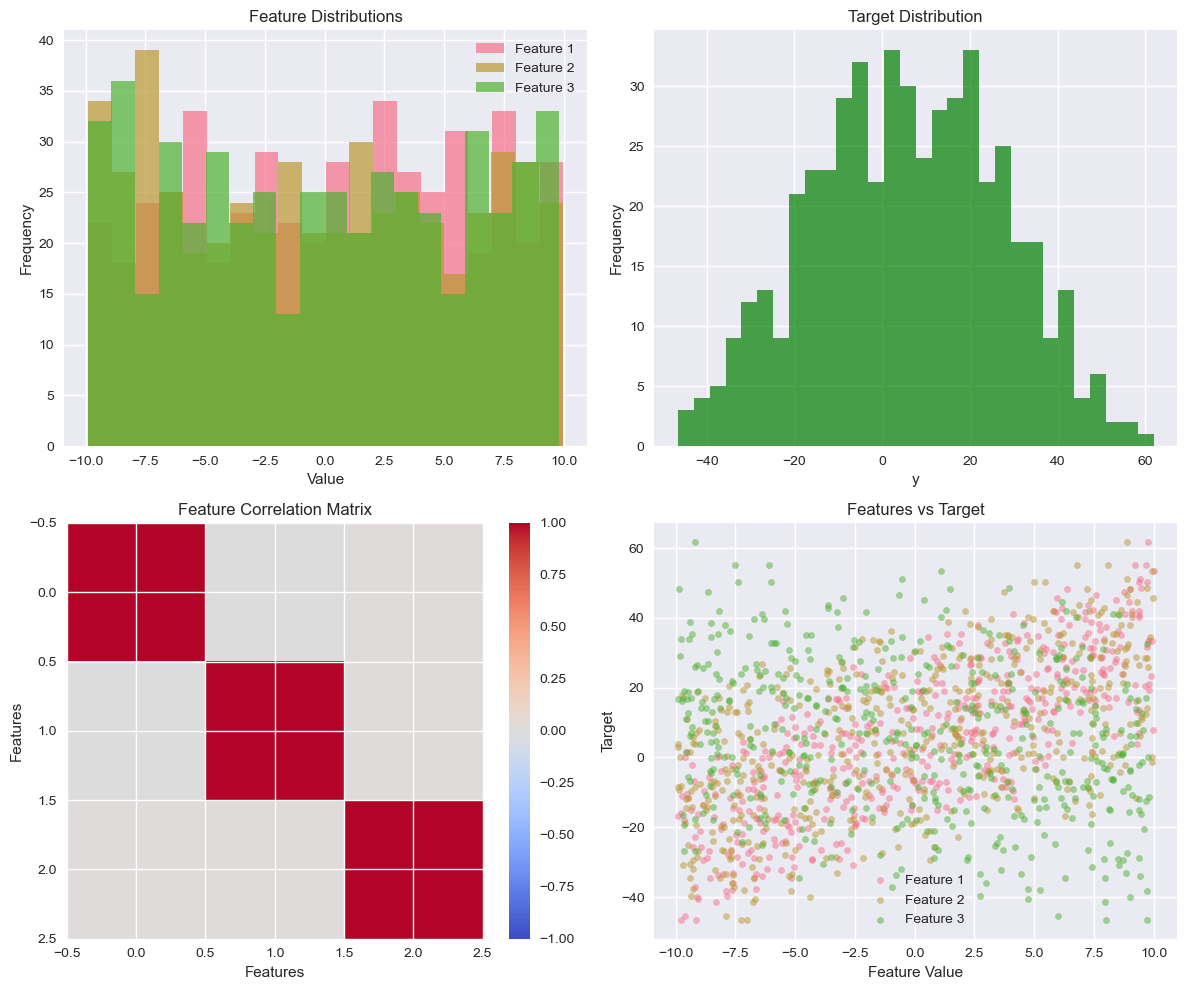

In [18]:
# Generate multiple features data
np.random.seed(42)
data_gen = DataGenerator(random_state=42)

# Tạo dữ liệu với 3 features: y = 3x1 + 2x2 - x3 + 5 + noise
X, y = data_gen.multiple(
    num_samples=500, 
    weights=np.array([3.0, 2.0, -1.0]), 
    bias=5.0, 
    noise_std=0.5,
    n_features=3
)

print(f"Data shape: X={X.shape}, y={y.shape}")
print(f"True weights: [3.0, 2.0, -1.0]")
print(f"True bias: 5.0")
print(f"X range: [{X.min():.2f}, {X.max():.2f}]")
print(f"y range: [{y.min():.2f}, {y.max():.2f}]")

# Visualize data
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Feature distributions
for i in range(3):
    axes[0, 0].hist(X[:, i], alpha=0.7, label=f'Feature {i+1}', bins=20)
axes[0, 0].set_title('Feature Distributions')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Target distribution
axes[0, 1].hist(y, bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('Target Distribution')
axes[0, 1].set_xlabel('y')
axes[0, 1].set_ylabel('Frequency')

# Feature correlations
correlation_matrix = np.corrcoef(X.T)
im = axes[1, 0].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[1, 0].set_title('Feature Correlation Matrix')
axes[1, 0].set_xlabel('Features')
axes[1, 0].set_ylabel('Features')
plt.colorbar(im, ax=axes[1, 0])

# Feature vs Target scatter
for i in range(3):
    axes[1, 1].scatter(X[:, i], y, alpha=0.5, label=f'Feature {i+1}', s=20)
axes[1, 1].set_title('Features vs Target')
axes[1, 1].set_xlabel('Feature Value')
axes[1, 1].set_ylabel('Target')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


## Train-Test Split và Feature Scaling

Trước khi train model, chúng ta cần chia dữ liệu và chuẩn hóa features.


Training set: X=(400, 3), y=(400,)
Test set: X=(100, 3), y=(100,)

Feature scaling results:
Original X_train mean: [ 0.36853019 -0.47551854 -0.40811694]
Original X_train std:  [5.75613286 5.966847   5.95033495]
Scaled X_train mean:   [ 1.47559916e-17 -8.38218384e-17  3.27515792e-17]
Scaled X_train std:    [1. 1. 1.]


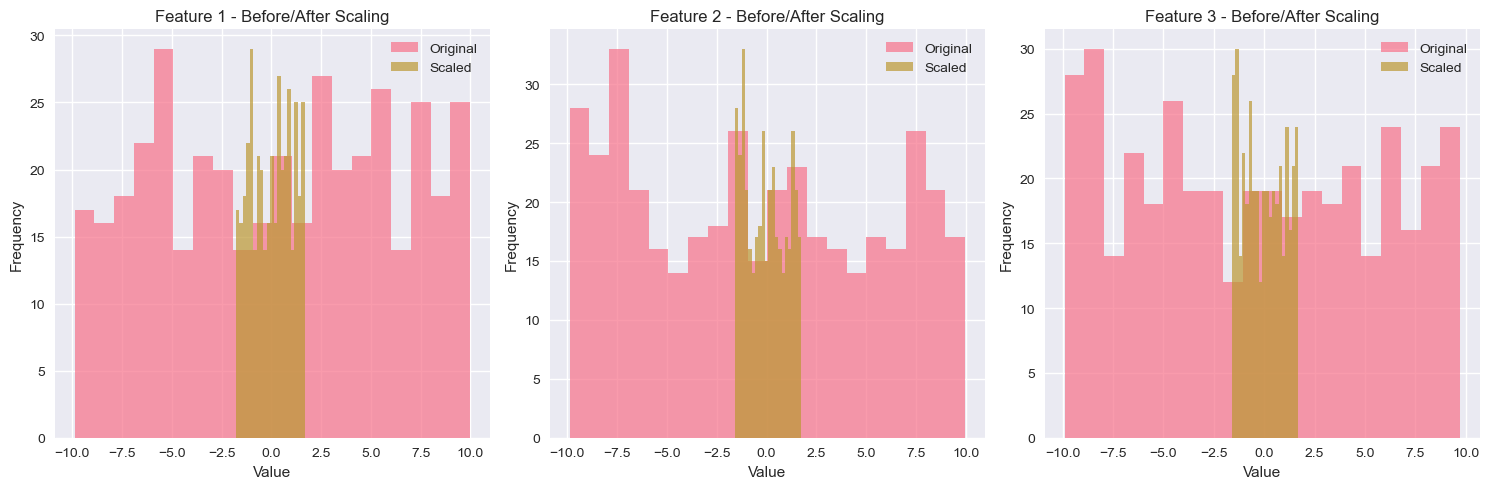

In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")

# Feature scaling
scaler = StandardScaler() # Chuẩn hóa đặc trưng
X_train_scaled = scaler.fit_transform(X_train) # Chuẩn hóa dữ liệu huấn luyện
X_test_scaled = scaler.transform(X_test) # Chuẩn hóa dữ liệu kiểm tra

print(f"\nFeature scaling results:")
print(f"Original X_train mean: {X_train.mean(axis=0)}")
print(f"Original X_train std:  {X_train.std(axis=0)}")
print(f"Scaled X_train mean:   {X_train_scaled.mean(axis=0)}")
print(f"Scaled X_train std:    {X_train_scaled.std(axis=0)}")

# Visualize scaling effect
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].hist(X_train[:, i], alpha=0.7, label='Original', bins=20)
    axes[i].hist(X_train_scaled[:, i], alpha=0.7, label='Scaled', bins=20)
    axes[i].set_title(f'Feature {i+1} - Before/After Scaling')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()


# ## Visualization và Phân tích Kết quả
# 
# Trong phần này, chúng ta sẽ visualize:
# - Quá trình học của model (learning curve)
# - So sánh giá trị thực tế vs dự đoán
# - Phân tích residuals để đánh giá chất lượng model
# 


## Multiple Linear Regression - No Regularization

Train model với dữ liệu đã được scaled.


Training model without regularization...
Iteration 0: Cost = 519.819609
Iteration 100: Cost = 66.080524
Iteration 200: Cost = 8.602544
Iteration 300: Cost = 1.311230
Iteration 400: Cost = 0.384942
Iteration 500: Cost = 0.267086
Iteration 600: Cost = 0.252067
Iteration 700: Cost = 0.250150
Converged at iteration 786

📊 Results - No Regularization
Learned weights: [17.23698602 11.90020921 -5.96310961]
Learned bias: 5.5731
Final cost: 0.249917

Performance:
Train MSE: 0.2499
Test MSE:  0.2843
Train R²:  0.9995
Test R²:   0.9992


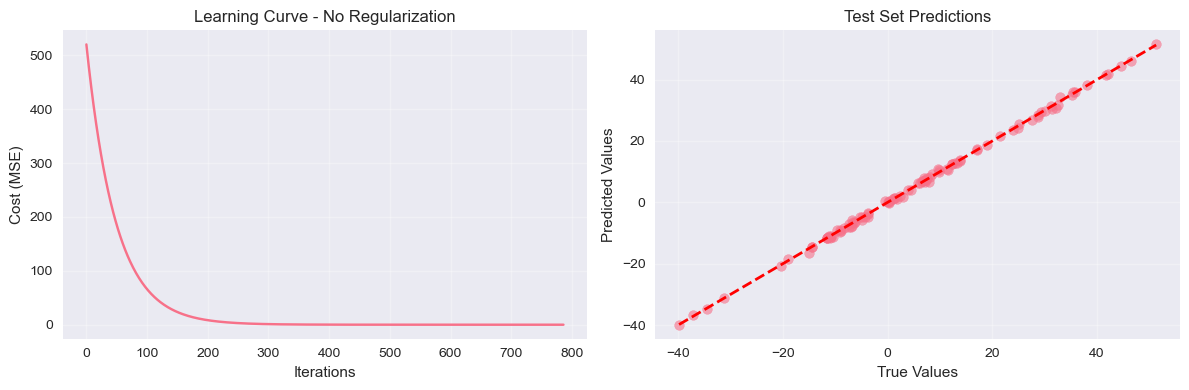

In [20]:
# Train Multiple Linear Regression without regularization
model_no_reg = MultipleLinearRegression(
    learning_rate=0.01,
    max_iterations=5000,
    regularization='none',
    random_state=42
)

print("Training model without regularization...")
model_no_reg.fit(X_train_scaled, y_train, verbose=True)

# Get parameters
params_no_reg = model_no_reg.get_parameters()

print(f"\n📊 Results - No Regularization")
print("=" * 50)
print(f"Learned weights: {params_no_reg['weights']}")
print(f"Learned bias: {params_no_reg['bias']:.4f}")
print(f"Final cost: {params_no_reg['cost_history'][-1]:.6f}")

# Predictions
y_pred_train = model_no_reg.predict(X_train_scaled)
y_pred_test = model_no_reg.predict(X_test_scaled)

# Metrics
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\nPerformance:")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE:  {test_mse:.4f}")
print(f"Train R²:  {train_r2:.4f}")
print(f"Test R²:   {test_r2:.4f}")

# Visualize learning curve
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(params_no_reg['cost_history'])
plt.title('Learning Curve - No Regularization')
plt.xlabel('Iterations')
plt.ylabel('Cost (MSE)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Test Set Predictions')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## So sánh với Regularization

Bây giờ hãy thử các loại regularization khác nhau và so sánh kết quả.


In [21]:
# Train models with different regularization
regularizations = ['ridge', 'lasso', 'elastic_net']
alphas = [0.01, 0.1, 1.0]
models = {}
results = {}

print("Training models with different regularizations...")
print("=" * 60)

for reg_type in regularizations:
    models[reg_type] = {}
    results[reg_type] = {}
    
    for alpha in alphas:
        print(f"\nTraining {reg_type.upper()} with alpha={alpha}")
        
        model = MultipleLinearRegression(
            learning_rate=0.01,
            max_iterations=5000,
            regularization=reg_type,
            alpha=alpha,
            random_state=42
        )
        
        model.fit(X_train_scaled, y_train, verbose=False)
        models[reg_type][alpha] = model
        
        # Get parameters and predictions
        params = model.get_parameters()
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
        
        # Calculate metrics
        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        
        results[reg_type][alpha] = {
            'weights': params['weights'],
            'bias': params['bias'],
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'cost_history': params['cost_history']
        }
        
        print(f"  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
        print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

# Add no regularization results
results['none'] = {
    'weights': params_no_reg['weights'],
    'bias': params_no_reg['bias'],
    'train_mse': train_mse,
    'test_mse': test_mse,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'cost_history': params_no_reg['cost_history']
}


Training models with different regularizations...

Training RIDGE with alpha=0.01
  Train MSE: 0.4275, Test MSE: 0.4067
  Train R²: 0.9991, Test R²: 0.9988

Training RIDGE with alpha=0.1
  Train MSE: 13.1800, Test MSE: 9.5893
  Train R²: 0.9730, Test R²: 0.9728

Training RIDGE with alpha=1.0
  Train MSE: 213.1590, Test MSE: 153.9659
  Train R²: 0.5639, Test R²: 0.5634

Training LASSO with alpha=0.01
  Train MSE: 0.2503, Test MSE: 0.2834
  Train R²: 0.9995, Test R²: 0.9992

Training LASSO with alpha=0.1
  Train MSE: 0.2790, Test MSE: 0.2953
  Train R²: 0.9994, Test R²: 0.9992

Training LASSO with alpha=1.0
  Train MSE: 3.1456, Test MSE: 2.2524
  Train R²: 0.9936, Test R²: 0.9936

Training ELASTIC_NET with alpha=0.01
  Train MSE: 0.2987, Test MSE: 0.3157
  Train R²: 0.9994, Test R²: 0.9991

Training ELASTIC_NET with alpha=0.1
  Train MSE: 4.3687, Test MSE: 3.2247
  Train R²: 0.9911, Test R²: 0.9909

Training ELASTIC_NET with alpha=1.0
  Train MSE: 127.8206, Test MSE: 92.0914
  Train R²: 

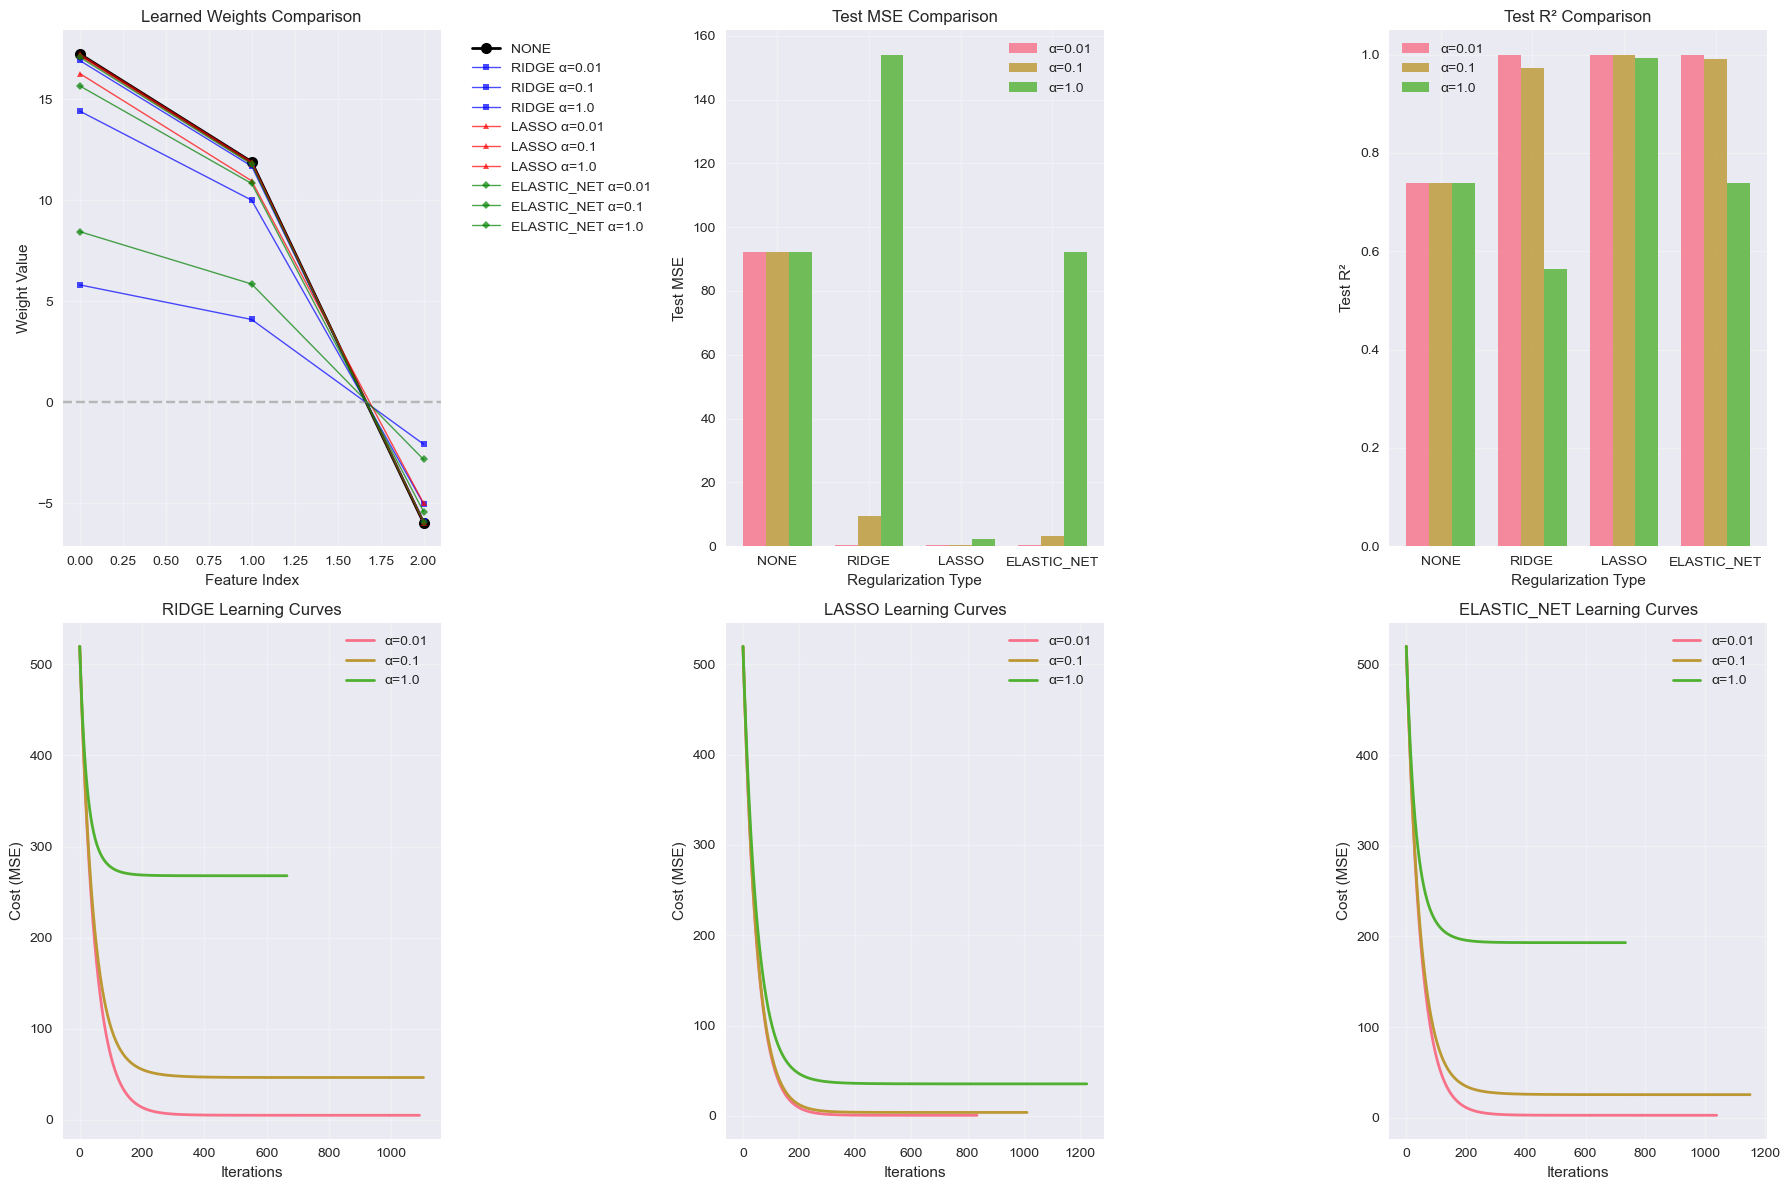


📊 Summary Table
Reg Type     Alpha    Train MSE  Test MSE   Train R²   Test R²   
--------------------------------------------------------------------------------
NONE         N/A      127.8206   92.0914    0.7385     0.7389    
RIDGE        0.01     0.4275     0.4067     0.9991     0.9988    
RIDGE        0.10     13.1800    9.5893     0.9730     0.9728    
RIDGE        1.00     213.1590   153.9659   0.5639     0.5634    
LASSO        0.01     0.2503     0.2834     0.9995     0.9992    
LASSO        0.10     0.2790     0.2953     0.9994     0.9992    
LASSO        1.00     3.1456     2.2524     0.9936     0.9936    
ELASTIC_NET  0.01     0.2987     0.3157     0.9994     0.9991    
ELASTIC_NET  0.10     4.3687     3.2247     0.9911     0.9909    
ELASTIC_NET  1.00     127.8206   92.0914    0.7385     0.7389    


In [22]:
# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Weights comparison
ax = axes[0, 0]
reg_types = ['none', 'ridge', 'lasso', 'elastic_net']
colors = ['black', 'blue', 'red', 'green']
markers = ['o', 's', '^', 'D']

for i, reg_type in enumerate(reg_types):
    if reg_type == 'none':
        weights = results[reg_type]['weights']
        ax.plot(range(len(weights)), weights, color=colors[i], marker=markers[i], 
                label=reg_type.upper(), linewidth=2, markersize=8)
    else:
        for alpha in alphas:
            weights = results[reg_type][alpha]['weights']
            ax.plot(range(len(weights)), weights, color=colors[i], marker=markers[i], 
                    alpha=0.7, label=f'{reg_type.upper()} α={alpha}', linewidth=1, markersize=4)

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Feature Index')
ax.set_ylabel('Weight Value')
ax.set_title('Learned Weights Comparison')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# Plot 2: Test MSE comparison
ax = axes[0, 1]
x_pos = np.arange(len(reg_types))
width = 0.25

for i, alpha in enumerate(alphas):
    mse_values = []
    for reg_type in reg_types:
        if reg_type == 'none':
            mse_values.append(results[reg_type]['test_mse'])
        else:
            mse_values.append(results[reg_type][alpha]['test_mse'])
    
    ax.bar(x_pos + i*width, mse_values, width, label=f'α={alpha}', alpha=0.8)

ax.set_xlabel('Regularization Type')
ax.set_ylabel('Test MSE')
ax.set_title('Test MSE Comparison')
ax.set_xticks(x_pos + width)
ax.set_xticklabels([r.upper() for r in reg_types])
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Test R² comparison
ax = axes[0, 2]
for i, alpha in enumerate(alphas):
    r2_values = []
    for reg_type in reg_types:
        if reg_type == 'none':
            r2_values.append(results[reg_type]['test_r2'])
        else:
            r2_values.append(results[reg_type][alpha]['test_r2'])
    
    ax.bar(x_pos + i*width, r2_values, width, label=f'α={alpha}', alpha=0.8)

ax.set_xlabel('Regularization Type')
ax.set_ylabel('Test R²')
ax.set_title('Test R² Comparison')
ax.set_xticks(x_pos + width)
ax.set_xticklabels([r.upper() for r in reg_types])
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4-6: Learning curves for each regularization type
for i, reg_type in enumerate(['ridge', 'lasso', 'elastic_net']):
    ax = axes[1, i]
    for alpha in alphas:
        cost_history = results[reg_type][alpha]['cost_history']
        ax.plot(cost_history, label=f'α={alpha}', linewidth=2)
    
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost (MSE)')
    ax.set_title(f'{reg_type.upper()} Learning Curves')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n📊 Summary Table")
print("=" * 80)
print(f"{'Reg Type':<12} {'Alpha':<8} {'Train MSE':<10} {'Test MSE':<10} {'Train R²':<10} {'Test R²':<10}")
print("-" * 80)

for reg_type in reg_types:
    if reg_type == 'none':
        print(f"{reg_type.upper():<12} {'N/A':<8} {results[reg_type]['train_mse']:<10.4f} {results[reg_type]['test_mse']:<10.4f} {results[reg_type]['train_r2']:<10.4f} {results[reg_type]['test_r2']:<10.4f}")
    else:
        for alpha in alphas:
            r = results[reg_type][alpha]
            print(f"{reg_type.upper():<12} {alpha:<8.2f} {r['train_mse']:<10.4f} {r['test_mse']:<10.4f} {r['train_r2']:<10.4f} {r['test_r2']:<10.4f}")


## 🎯 Kết luận Multiple Linear Regression

### Key Insights:
- ✅ **Feature Scaling**: Quan trọng cho gradient descent convergence
- ✅ **Regularization**: Ridge, Lasso, Elastic Net có tác động khác nhau lên weights
- ✅ **Overfitting**: Regularization giúp giảm overfitting
- ✅ **Model Selection**: Cần balance giữa bias và variance

**Bước tiếp theo**: Chuyển sang notebook 04 để deep dive vào Gradient Descent!

### 1. 📏 Feature Scaling - Tại sao lại quan trọng?

**Vấn đề khi không có Feature Scaling:**
- Khi các features có scale khác nhau (ví dụ: tuổi từ 20-80, lương từ 30,000-100,000), gradient descent sẽ gặp khó khăn
- Các features có giá trị lớn sẽ dominante quá trình học, làm cho model bias về những features này
- Learning rate phải được set rất nhỏ để tránh overshooting, dẫn đến convergence chậm

**Lợi ích của Feature Scaling:**
- Tất cả features đều có cùng scale (thường là 0-1 hoặc mean=0, std=1)
- Gradient descent converge nhanh hơn và ổn định hơn
- Learning rate có thể được set cao hơn mà không lo overshooting
- Model không bị bias về features có giá trị lớn

**Khi nào cần Feature Scaling:**
- Luôn luôn cần khi sử dụng gradient descent
- Đặc biệt quan trọng với regularization (Ridge, Lasso, Elastic Net)
- Không cần thiết với closed-form solution (Normal Equation) nhưng vẫn nên làm để consistency

### 2. 🎛️ Regularization - Kiểm soát Model Complexity

**Ridge Regression (L2 Regularization):**
- Thêm penalty term: λ * Σ(wi²) vào cost function
- Shrink tất cả weights về gần 0 nhưng không bao giờ = 0
- Tốt khi tất cả features đều có ít nhiều relevance
- Giúp giảm variance nhưng có thể tăng bias một chút
- Stable và robust với multicollinearity

**Lasso Regression (L1 Regularization):**
- Thêm penalty term: λ * Σ|wi| vào cost function
- Có thể đưa một số weights về chính xác = 0 (feature selection)
- Tốt khi có nhiều irrelevant features cần loại bỏ
- Tạo ra sparse model (ít features)
- Có thể unstable khi có multicollinearity

**Elastic Net (L1 + L2):**
- Kết hợp cả L1 và L2: λ1 * Σ|wi| + λ2 * Σ(wi²)
- Có được ưu điểm của cả Ridge và Lasso
- Feature selection như Lasso nhưng stable như Ridge
- Tốt nhất khi có nhiều features và một số có correlation

**Hyperparameter α (lambda):**
- α = 0: Không có regularization (có thể overfit)
- α nhỏ: Ít regularization, model phức tạp hơn
- α lớn: Nhiều regularization, model đơn giản hơn (có thể underfit)
- Cần cross-validation để tìm α optimal

### 3. 🚫 Overfitting - Kẻ thù của Generalization

**Dấu hiệu của Overfitting:**
- Train accuracy cao nhưng test accuracy thấp
- Model quá phức tạp so với lượng data
- Weights có giá trị rất lớn (không regularized)
- Learning curve: train error giảm nhưng validation error tăng

**Tại sao Regularization giúp giảm Overfitting:**
- Penalty term buộc model phải "trả giá" cho complexity
- Weights bị shrink về 0, giảm model capacity
- Model buộc phải focus vào patterns quan trọng nhất
- Tạo ra smoother decision boundary

**Strategies khác để giảm Overfitting:**
- Tăng training data (nếu có thể)
- Feature selection/engineering
- Cross-validation để model selection
- Early stopping trong iterative algorithms
- Ensemble methods (bagging, boosting)

### 4. ⚖️ Model Selection - Balance giữa Bias và Variance

**Bias-Variance Tradeoff:**
- **High Bias, Low Variance**: Model quá đơn giản (underfit)
  - Ví dụ: Linear model cho non-linear data
  - Consistent nhưng inaccurate predictions
- **Low Bias, High Variance**: Model quá phức tạp (overfit)
  - Ví dụ: High-degree polynomial với ít data
  - Accurate trên training nhưng unstable trên new data
- **Sweet Spot**: Balance optimal giữa bias và variance

**Cách đánh giá Model Selection:**
- **Cross-Validation**: K-fold CV để estimate generalization performance
- **Learning Curves**: Plot training vs validation error theo training size
- **Validation Curves**: Plot performance theo hyperparameter values
- **Information Criteria**: AIC, BIC để penalize complexity

**Practical Model Selection Process:**
1. **Data Splitting**: Train/Validation/Test (60/20/20)
2. **Hyperparameter Tuning**: Grid search hoặc random search trên validation set
3. **Model Comparison**: So sánh different algorithms/regularization types
4. **Final Evaluation**: Test trên test set chỉ 1 lần duy nhất
5. **Cross-Validation**: Nếu data ít, dùng k-fold CV thay vì simple split

**Red Flags trong Model Selection:**
- Test accuracy cao bất thường (có thể data leakage)
- Huge gap giữa train và validation performance
- Model performance không stable across different random seeds
- Hyperparameters ở boundary của search space

### 🎯 Tổng kết và Next Steps

**Những gì đã học được:**
- Multiple Linear Regression là foundation cho nhiều advanced techniques
- Feature engineering và scaling là crucial cho model performance
- Regularization là powerful tool để control overfitting
- Model selection cần systematic approach, không phải guess-and-check

**Best Practices:**
- Luôn luôn scale features khi dùng gradient descent
- Start với simple model rồi gradually tăng complexity
- Use cross-validation để avoid overfitting trong model selection
- Monitor cả training và validation metrics
- Document experiments và hyperparameters để reproducibility
